In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
features = pd.read_pickle('data/top15.pkl')

In [3]:
target = pd.DataFrame()

In [4]:
for i in range (1, 25):
    target[f'flow_{i}'] = features.flow.shift(-i)

In [5]:
target = target[0: -24]

In [6]:
features = features.drop(['flow'], axis=1)[0:-24]

In [7]:
print(features.shape)
print(target.shape)

(39625, 14)
(39625, 24)


In [8]:
train_split = 0.9
num_train = int(train_split * len(features))
num_test = len(features) - num_train

In [9]:
x_train = features.iloc[0:num_train , :]
x_test = features.iloc[num_train+1: , :]

y_train = target.iloc[0:num_train: , :]
y_test = target.iloc[num_train+1: , :]

In [10]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [11]:
x_test_scaled = x_scaler.transform(x_test)

In [12]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [13]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training data
    """
    
    num_x_signals = features.shape[1]
    num_y_signals = target.shape[1]
    
    # infinite loop
    while True:
        # Allocate a new array for the batch of input signals
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        
        # Allocate a new array for the batch of output signals 
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        
        # Fill the batch with random sequences of data
        for i in range(batch_size):
            # Get a random start_index
            # This points somewhere in the training data
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequence of data starting from this index
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
            
        yield (x_batch, y_batch)

In [14]:
batch_size = 256
sequence_length = 24 * 7 * 4

In [15]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [16]:
x_batch, y_batch = next(generator)

In [17]:
x_batch.shape ,y_batch.shape

((256, 672, 14), (256, 672, 24))

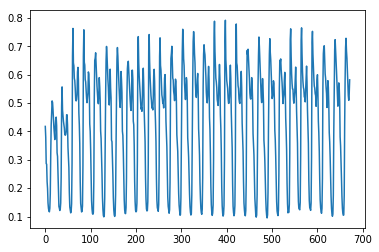

In [18]:
batch = 0 
signal = 0
seq = x_batch[batch , : , signal]
plt.plot(seq)

In [19]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [20]:
validation_data

(array([[[0.25100835, 0.35583965, 1.        , ..., 0.07901907,
          0.        , 0.2602072 ],
         [0.168977  , 0.25100835, 0.        , ..., 0.09809264,
          0.        , 0.21596345],
         [0.13844824, 0.168977  , 0.04347826, ..., 0.09809264,
          0.        , 0.20982522],
         ...,
         [0.48011834, 0.61165498, 0.95652174, ..., 0.        ,
          1.        , 0.08713763],
         [0.30720161, 0.48011834, 1.        , ..., 0.        ,
          1.        , 0.05405796],
         [0.20017873, 0.30720161, 0.        , ..., 0.        ,
          1.        , 0.03153925]]]),
 array([[[0.19920021, 0.19411857, 0.18474761, ..., 0.47135786,
          0.41873934, 0.31806168],
         [0.19411857, 0.18474761, 0.19513088, ..., 0.41873934,
          0.31806168, 0.24065461],
         [0.18474761, 0.19513088, 0.24796345, ..., 0.31806168,
          0.24065461, 0.21689779],
         ...,
         [0.30959703, 0.24695098, 0.18772454, ..., 0.65976314,
          0.60173828, 0.

## The LSTM model

In [21]:
model = Sequential()
model.add(LSTM(units=52,
               input_shape=(None, features.shape[1],),
               return_sequences=True,dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(target.shape[1], activation='sigmoid'))

W0809 14:05:15.858407 140736267588480 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Loss function

In [22]:
warmup_steps = 30

In [23]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the mean squared error between y_true and y_pred but ignores the warmup-period of the sequence,
    as there is not yet enough data to make serious predictions.
    """
    
    # The shape of both input tensors are 
    # (batch_size, sequence_length, num_y_signals)
    
    # Ignore the warm-up period by taking slices of the tensors
    y_true_slice = y_true[: , warmup_steps: , :]
    y_pred_slice = y_pred[: , warmup_steps: , :]
    
    # The sliced tensors have the shape (batch_size, sequence_length - warmup_length, num_y_signals)
    
    # Calculate the MSE loss for each value pair
    loss = tf.losses.mean_squared_error(labels=y_true_slice, predictions=y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

In [24]:
optimizer = RMSprop(lr=1e-3)

In [25]:
model.compile(loss='mse', optimizer=optimizer)

In [26]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [27]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [28]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        verbose=1)

In [29]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [30]:
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=[callback_checkpoint, callback_reduce_lr, callback_early_stopping, callback_tensorboard])

Epoch 1/20
  1/100 [..............................] - ETA: 15:43 - loss: 0.0382

W0809 14:06:39.570506 140736267588480 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (31.938319). Check your callbacks.


 99/100 [============================>.] - ETA: 4s - loss: 0.0238
Epoch 00001: val_loss improved from inf to 0.01324, saving model to 23_checkpoint.keras
100/100 [==============================] - 422s 4s/step - loss: 0.0238 - val_loss: 0.0132
Epoch 2/20
 99/100 [============================>.] - ETA: 4s - loss: 0.0153
Epoch 00002: val_loss improved from 0.01324 to 0.00828, saving model to 23_checkpoint.keras
100/100 [==============================] - 412s 4s/step - loss: 0.0153 - val_loss: 0.0083
Epoch 3/20
 99/100 [============================>.] - ETA: 3s - loss: 0.0130
Epoch 00003: val_loss improved from 0.00828 to 0.00751, saving model to 23_checkpoint.keras
100/100 [==============================] - 370s 4s/step - loss: 0.0130 - val_loss: 0.0075
Epoch 4/20
 99/100 [============================>.] - ETA: 3s - loss: 0.0117
Epoch 00004: val_loss improved from 0.00751 to 0.00699, saving model to 23_checkpoint.keras
100/100 [==============================] - 327s 3s/step - loss: 0.011